# Machine Learning for Authorship Attribution

From Chapter 5 of Getting Started with Natural Language Processing (2022, Kochmar)

The goal of this notebook is to train and evaluate a machine learning algorithm to classify a sentence as written by one of two authors (classification).

# 1. Preliminary Steps

In [1]:
# imports
import nltk
from nltk.corpus import gutenberg # data for training
import random
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from nltk import NaiveBayesClassifier, classify, DecisionTreeClassifier
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
import operator

# # if first time running, may also need:
# nltk.download('punkt') # sentence tokenizer
# nltk.download('gutenberg')

In [2]:
# select data for training

gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
# shakespeare and austen each have three attributed works, so we will use
# them as our data

# will use 2 works from each author as training and pretest data; third work
# will be reserved for testing data

# create training and testing data sentences for author1 (austen)
author1_train = gutenberg.sents('austen-emma.txt') + \
                gutenberg.sents('austen-persuasion.txt')
author1_test = gutenberg.sents('austen-sense.txt')

# create training and testing data sentences for author1 (shakespeare)
author2_train = gutenberg.sents('shakespeare-caesar.txt') + \
                gutenberg.sents('shakespeare-hamlet.txt')
author2_test = gutenberg.sents('shakespeare-macbeth.txt')

# check length of data sets
print(f"Author 1 training set length: {len(author1_train)} sentences")
print(f"Author 1 testing set length: {len(author1_test)} sentences")
print(f"Author 2 training set length: {len(author2_train)} sentences")
print(f"Author 2 testing set length: {len(author2_test)} sentences")

Author 1 training set length: 11464 sentences
Author 1 testing set length: 4999 sentences
Author 2 training set length: 5269 sentences
Author 2 testing set length: 1907 sentences


# 2. Statistics comparing authors

In [4]:
# define helper function to calculate statistics
def statistics(gutenberg_data):
    
    # iterate over works given
    for work in gutenberg_data:
        
        # number of characters in a work
        num_chars = len(gutenberg.raw(work))
        
        # number of words in a work
        num_words = len(gutenberg.words(work))
        
        # number of sentences in a work
        num_sents = len(gutenberg.sents(work))
        
        # number of unique words in a work (python set over list of all words)
        num_vocab = len(set(w.lower() for w in gutenberg.words(work)))
        
        print(
            # average length of words
            round(num_chars/num_words),
            
            # average length of sentences
            round(num_words/num_sents),
            
            # average number of times each word is used in a text by the author
            round(num_words/num_vocab),
            
            # name of work
            work
        )

In [5]:
# make list of works to get statistics for
gutenberg_data = ['austen-emma.txt', 'austen-persuasion.txt', 
                  'austen-sense.txt', 'shakespeare-caesar.txt', 
                  'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']

In [6]:
# run statistics function on list of works
statistics(gutenberg_data)

5 25 26 austen-emma.txt
5 26 17 austen-persuasion.txt
5 28 22 austen-sense.txt
4 12 9 shakespeare-caesar.txt
4 12 8 shakespeare-hamlet.txt
4 12 7 shakespeare-macbeth.txt


Austen on average uses slightly longer words than Shakespeare (an average of 5 letters to 4). She also uses much longer sentences (an average of 25-28 words, depending on the text, to 12). Perhaps influenced by the length of her works, the average number of times a single word is used across a whole text by Austen ranges from 17-26, while Shakespeare's words only get repeated an average of 7-9 times.

# 3. Split data into training and pretesting sets

In [7]:
# add all sentences in training set to list, keeping author label
all_sents = [(sent, "austen") for sent in author1_train]
all_sents += [(sent, "shakespeare") for sent in author2_train]

# check number of sentences in all_sents
print(f"Training set length: {str(len(all_sents))} sentences")

Training set length: 16733 sentences


In [8]:
# keep set of labels (authors) as values
values = [author for (sent, author) in all_sents]

# instantiate stratified shuffle split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# create empty lists for train and pretest sets
strat_train_set = []
strat_pretest_set = []

# perform split
for train_index, pretest_index in split.split(all_sents, values):
    strat_train_set = [all_sents[index] for index in train_index]
    strat_pretest_set = [all_sents[index] for index in pretest_index]

In [9]:
# set test_set data to same structure as strat_train_set and strat_pretest_set
test_set = [(sent, "austen") for sent in author1_test]
test_set += [(sent, "shakespeare") for sent in author2_test]

In [10]:
# check the proportions of the data in sets: 
# overall (strat_train and strat_pretest), strat_train_set, strat_pretest_set, and test_set

# define helper function to calculate proportions
def cat_proportions(data, cat):
    
    # initialize count of sentences
    count = 0
    
    # iterate over sentences in data
    for item in data:
        
        # if the item's author is cat
        if item[1] == cat:
            
            # increment count
            count += 1
    
    # return proportion
    return float(count) / float(len(data))

# set authors as categories
categories = ["austen", "shakespeare"]

# create rows for table
rows = []
rows.append(["Category", "(strat_train_set and strat_pretest_set)", 
             "strat_train_set", "strat_pretest_set", "test_set"])

# populate list for rows
for cat in categories:
    rows.append([cat, 
                 f"{cat_proportions(all_sents, cat): .6f}",
                 f"{cat_proportions(strat_train_set, cat): .6f}",
                 f"{cat_proportions(strat_pretest_set, cat): .6f}",
                 f"{cat_proportions(test_set, cat): .6f}"])

# make table, adjust column widths, and populate rows
columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width = column_widths[i])
                 for i in range(0, len(row))))

 Category     (strat_train_set and strat_pretest_set)  strat_train_set  strat_pretest_set  test_set  
 austen        0.685113                                 0.685119         0.685091           0.723863 
 shakespeare   0.314887                                 0.314881         0.314909           0.276137 


# 4. Extract words as features

In [11]:
# create function
def get_features(text):
    
    # create empty dictionary
    features = {}
    
    # create word list from text
    word_list = [word for word in text]
    
    # iterate over word_list
    for word in word_list:
        
        # set a presence flag to "True" in dictionary
        features[word] = True
    
    # return dictionary of features
    return features

# get feature dictionary for strat_train_set and strat_pretest_set
train_features = [(get_features(sents), label) for (sents, label) in strat_train_set]
pretest_features = [(get_features(sents), label) for (sents, label) in strat_pretest_set]

# checks
print(len(train_features))
print(len(pretest_features))

13386
3347


# 5. Naive Bayes

## 5.1 Train NB classifier and evaluate on training data

In [12]:
# show size of training data set
print(f"Training set size: {str(len(train_features))} sentences")

# train classifier on training features
classifier = NaiveBayesClassifier.train(train_features)

# print accuracy on training data set
print(f"Accuracy on the training set: {str(classify.accuracy(classifier, train_features))}")

Training set size: 13386 sentences
Accuracy on the training set: 0.9783355744808009


In [13]:
# show most informative features
classifier.show_most_informative_features(50)

Most Informative Features
                    King = True           shakes : austen =    202.3 : 1.0
                    thou = True           shakes : austen =    192.2 : 1.0
                    been = True           austen : shakes =    154.5 : 1.0
                    only = True           austen : shakes =    125.2 : 1.0
                     own = True           austen : shakes =    105.6 : 1.0
                       d = True           shakes : austen =     65.2 : 1.0
                    doth = True           shakes : austen =     60.2 : 1.0
                   quite = True           austen : shakes =     52.1 : 1.0
                     Tis = True           shakes : austen =     50.0 : 1.0
                    Lord = True           shakes : austen =     48.9 : 1.0
                   think = True           austen : shakes =     41.5 : 1.0
                     She = True           austen : shakes =     38.2 : 1.0
                     few = True           austen : shakes =     36.0 : 1.0

## 5.2 Evaluate on Pretest Data

In [14]:
# show size of pretest data set
print(f"Pretest set size: {str(len(pretest_features))} sentences")

# print accuracy on training data set
print(f"Accuracy on the pretest set: {str(classify.accuracy(classifier, pretest_features))}")

Pretest set size: 3347 sentences
Accuracy on the pretest set: 0.9611592470869436


## 5.3 Evaluate on Test Data

In [15]:
# get features from test set data
test_features = [(get_features(sents), label) for (sents, label) in test_set]

# show size of test data set
print(f"Test set size: {str(len(test_features))}")

# print accuracy on the test set (which consists of a different literary work for each author)
print(f"Accuracy on the test set: {str(classify.accuracy(classifier, test_features))}")

Test set size: 6906
Accuracy on the test set: 0.8964668404286128


Accuracy of the classifier on the training and pretest data is relatively comparable (about 0.98 to 0.96). Both these data sets consist of sentences from two works from each author. 

The accuracy of the classifier on the test data drops significantly (to about 0.90). The test set consists of sentences from one new work from each author that was not included in the training and test sets. This indicates that the classifier is overfitting on the training data.

# 6. Decision Tree

## 6.1 Feature Selection

In [16]:
# select middle range of features to run DT on
# this will speed up the algorithm (13,553 features without selection)
# words that occur across most texts are not informative, since they are used by both authors
# words that occur very infreqently, even if they clearly indicate one authorship, will probably not be seen in the test data

# create empty list to store words
words = []

# define helper function that will return the set of all words in a text
def extract_words(text, words):
    
    # add to words list: the set of every word in the text
    words += set([word for word in text])
    
    # return words list
    return words

In [17]:
# iterate over strat_train_set
for (sents, label) in strat_train_set:
    
    # run helper function extract_words
    words = extract_words(sents, words)

In [18]:
# count words with Counter; this calculates document frequency for each word in training set
counts = Counter(words)

# check
print(counts)

Counter({'.': 9090, ',': 7147, 'to': 4356, 'the': 4106, 'and': 3996, 'of': 3812, 'a': 3054, 'I': 2959, 'in': 2442, 'not': 2411, ';': 2389, 'was': 2290, 'it': 2219, 'be': 2131, 'that': 1958, '"': 1913, 'her': 1891, 'you': 1889, "'": 1723, 'had': 1608, 'for': 1533, 'with': 1508, 'is': 1484, 'she': 1472, 'but': 1417, 'he': 1376, 'as': 1353, 'have': 1315, '."': 1235, 'his': 1232, 'at': 1166, 'very': 1153, 's': 1110, 'all': 1080, 'him': 1049, 'Mr': 1028, 'so': 1027, 'my': 981, 'could': 935, 'on': 887, 'would': 879, '?': 855, ':': 844, 'been': 842, 'me': 838, '--': 833, 'no': 783, 'by': 777, 'were': 761, 'this': 734, 'Mrs': 725, 'which': 715, 'She': 713, 'do': 713, 'will': 701, '-': 686, '!': 682, 'Emma': 681, 'from': 671, 'must': 664, 'any': 638, 'more': 618, 'The': 618, 'He': 603, 'are': 599, 'what': 596, 'them': 595, 'or': 585, 'they': 576, 'an': 574, 'much': 573, 'And': 552, 'your': 552, 'there': 544, 'said': 541, 'It': 535, 'Miss': 527, ',"': 523, 'good': 507, 'one': 506, 'such': 502, '

In [19]:
# visualize word document frequencies to show many words are too frequent or too infrequent to be informative
# (Zipf's law)

df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df.rename(columns = {0: 'occurrences'}, inplace = True)

# check
df.head()

,index,occurrences
0,Why,95
1,you,1889
2,aske,4
3,this,734
4,?,855


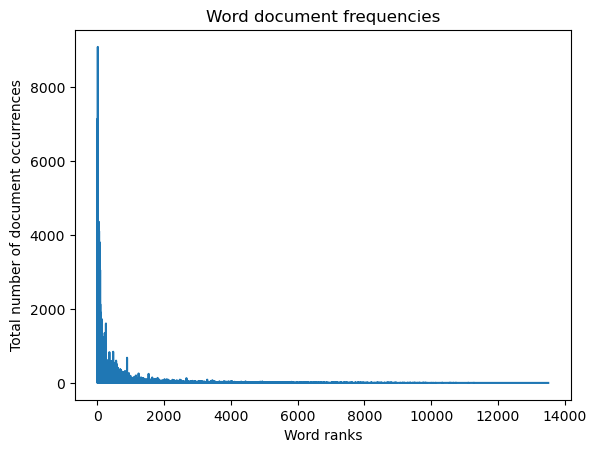

In [20]:
# plot frequencies
plt.plot(df['occurrences'])
plt.xlabel("Word ranks")
plt.ylabel("Total number of document occurrences")
plt.title("Word document frequencies");

In [21]:
# get selected features for DT classifier

# max number of sentences in which a word may occur is 13,414
maximum = float(13414)

# create empty list to store selected words (features)
selected_words = []

# select only words that occur in:
# 1. more than 200 sentences, and
# 2. less than 20% of sentences (2,683)

# iterate over counts' items
for item in counts.items():
    
    # assign float of number of occurrences to count
    count = float(item[1])
    
    # set thresholds
    if count > 200 and count / maximum < 0.2:
        
        # append word to selected_words list
        selected_words.append(item[0])

# check
print(len(selected_words))

165


In [22]:
# define helper function to extract features from sentences only using words from selected_words
def get_features(text, selected_words):
    features = {}
    word_list = [word for word in text]
    for word in word_list:
        if word in selected_words:
            features[word] = True
    return features

In [23]:
# set features for training, pretest, and testing set

train_features2 = [(get_features(sents, selected_words), label)
                 for (sents, label)
                 in strat_train_set]

pretest_features2 = [(get_features(sents, selected_words), label)
                 for (sents, label)
                 in strat_pretest_set]

test_features2 = [(get_features(sents, selected_words), label)
                 for (sents, label)
                 in test_set]

## 6.2 Train DT classifier and evaluate on training data

In [24]:
# fit DT classifier on training data only
dt_classifier = DecisionTreeClassifier.train(train_features2)

In [25]:
# show size of training data set
print(f"DT Training set size: {str(len(train_features2))} sentences")

# print accuracy on training data set
print(f"DT Accuracy on the training set: {str(classify.accuracy(dt_classifier, train_features2))}")

DT Training set size: 13386 sentences
DT Accuracy on the training set: 0.8093530554310474


## 6.3 Evaluate DT on Pretest Data

In [26]:
# show size of pretest data set
print(f"DT Pretest set size: {str(len(pretest_features2))} sentences")

# print accuracy on pretest data set
print(f"DT Accuracy on the pretest set: {str(classify.accuracy(dt_classifier, pretest_features2))}")

DT Pretest set size: 3347 sentences
DT Accuracy on the pretest set: 0.7932476844935763


## 6.4 Evaluate DT on Test Data

In [27]:
# show size of test data set
print(f"DT Test set size: {str(len(test_features2))}")

# print accuracy on the test set (which consists of a different literary work for each author)
print(f"DT Accuracy on the test set: {str(classify.accuracy(dt_classifier, test_features2))}")

DT Test set size: 6906
DT Accuracy on the test set: 0.8075586446568201


Accuracy of the Decision Tree Classifier on all three data sets (training, pretest, and testing) is relatively comparable (about 0.81 to 0.79 to 0.81). This indicates that the model is truly learning, and is not overfitting like the Naive Bayes Classifier. It is more generalizable to new data.

The Decision Tree Classifier has also been trained on many fewer features (166 vs. 13,553). 

# Linguistic Feature Engineering for Author Profiling

From Chapter 6 of Getting Started with Natural Language Processing (2022, Kochmar)

The goal of this notebook is to try more feature engineering on our data to enhance the performance of our classifier.

## 7.1 Word and Sentence Length as Features

In [28]:
# define helper function to calculate number of characters
# per word in a sentence
def avg_number_chars(text):
    
    # instantiate total_chars variable
    total_chars = 0.0
    
    # iterate over words in text
    for word in text:
        
        # add up the number of characters in each word
        total_chars += len(word)
        
    # return avg length of word
    return float(total_chars) / float(len(text)) 

In [29]:
# define helper function to calculate number of words
# in a sentence
def number_words(text):
    
    # return number of words
    return float(len(text))

In [30]:
# check
example = ['Not', 'so', 'happy', ',', 'yet', 'much', 'happyer']
print(f"Example sentence: {example}")
print(f"Average number of characters per word in sentence: {avg_number_chars(example)}")
print(f"Number of words in sentence: {number_words(example)}")

Example sentence: ['Not', 'so', 'happy', ',', 'yet', 'much', 'happyer']
Average number of characters per word in sentence: 3.5714285714285716
Number of words in sentence: 7.0


In [31]:
# data currently in three sets: strat_train_set, strat_pretest_set, and test_set
# each set is a list of tuples with two elements each:
# 1. a list of words in a sentence (sent)
# 2. the attributed author as a string (label)

# create lists with two elements for each sentence:
# 1. avg_number_chars
# 2. number_words

# append each list to one big list (all_features)
# append to a separate big list (targets) a numeric encoding for the author
# (0 for 'austen' and 1 for 'shakespeare')

def initialize_dataset(source):
    all_features = []
    targets = []
    for sent, label in source:
        feature_list = []
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        all_features.append(feature_list)
        if label == 'austen':
            targets.append(0)
        elif label == 'shakespeare':
            targets.append(1)
    return all_features, targets

# check
initialize_dataset(strat_train_set)

([[3.0, 5.0],
  [3.466666666666667, 15.0],
  [4.536585365853658, 41.0],
  [2.0, 2.0],
  [3.0555555555555554, 18.0],
  [4.095238095238095, 21.0],
  [3.7777777777777777, 27.0],
  [3.6363636363636362, 22.0],
  [3.9473684210526314, 38.0],
  [2.0, 2.0],
  [3.4, 5.0],
  [3.3461538461538463, 26.0],
  [3.0, 14.0],
  [4.0, 6.0],
  [3.4, 60.0],
  [4.076923076923077, 26.0],
  [4.25, 16.0],
  [2.0, 6.0],
  [3.227272727272727, 22.0],
  [2.8, 5.0],
  [3.5, 6.0],
  [2.0, 2.0],
  [2.5, 2.0],
  [3.6097560975609757, 41.0],
  [3.625, 16.0],
  [4.125, 24.0],
  [3.0, 2.0],
  [4.078947368421052, 76.0],
  [3.619047619047619, 21.0],
  [4.487179487179487, 39.0],
  [4.333333333333333, 12.0],
  [3.3636363636363638, 11.0],
  [3.0, 2.0],
  [4.0, 17.0],
  [3.28125, 32.0],
  [3.6097560975609757, 41.0],
  [5.0, 6.0],
  [3.375, 16.0],
  [3.642857142857143, 14.0],
  [3.0657894736842106, 76.0],
  [4.0, 8.0],
  [3.2142857142857144, 14.0],
  [3.8372093023255816, 43.0],
  [3.7027027027027026, 74.0],
  [2.0, 2.0],
  [3.8214

In [32]:
# get all_features and targets for all data sets
train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set)

# check
print(len(train_data), len(train_targets))
print(len(pretest_data), len(pretest_targets))
print(len(test_data), len(test_targets))

13386 13386
3347 3347
6906 6906


In [33]:
# import DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# initialize new dt classifier from sklearn
dt_classifier2 = DecisionTreeClassifier(random_state = 42)

# fit on training data only
dt_classifier2.fit(train_data, train_targets)

# make predictions on pretest set
predicted_pretest = dt_classifier2.predict(pretest_data)

In [34]:
# define helper function to evaluate predictions
def evaluate(predicted, targets):
    
    # print the accuracy score
    print(f"Accuracy: {np.mean(predicted == targets)}")
    print()
    
    # print the confusion matrix
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(targets, predicted))
    print()
    
    # print the classification report
    print("Classification Report:")
    print(metrics.classification_report(targets, predicted))

In [35]:
# evaluate dt_classifier2 on pretest
evaluate(predicted_pretest, pretest_targets)

Accuracy: 0.804302360322677

Confusion Matrix:
[[2148  145]
 [ 510  544]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2293
           1       0.79      0.52      0.62      1054

    accuracy                           0.80      3347
   macro avg       0.80      0.73      0.75      3347
weighted avg       0.80      0.80      0.79      3347



In [36]:
# make predictions on test set
predicted_test = dt_classifier2.predict(test_data)

# evaluate dt_classifier2 on test
evaluate(predicted_test, test_targets)

Accuracy: 0.8036490008688097

Confusion Matrix:
[[4576  423]
 [ 933  974]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4999
           1       0.70      0.51      0.59      1907

    accuracy                           0.80      6906
   macro avg       0.76      0.71      0.73      6906
weighted avg       0.79      0.80      0.79      6906



## 7.2 Counts and Proportion of Stopwords as Features

In [37]:
# helper function to count words in text
def word_counts(text):
    counts = {}
    for word in text:
        counts[word.lower()] = counts.get(word.lower(), 0) + 1
    return counts

# helper function to calculate number of words in a wordlist
# against all other words in a text
def proportion_words(text, wordlist):
    count = 0
    for word in text:
        if word.lower() in wordlist:
            count += 1
        return float(count) / float(len(text))

In [38]:
# use stopwords list from spaCy (305 stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [39]:
# create spacy nlp object with medium model
nlp = spacy.load('en_core_web_md')

In [40]:
# define revised helper function to initialize dataset
# with the following feature set additions:

# add a new feature to feature set for each of 305 stopwords,
# indicating how many times that stopword is used on average 
# in a sentence

# add one new feature to feature set that indicates the
# average proportion of stopwords to all words

def initialize_dataset(source):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list = []
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)
        feature_list.append(proportion_words(sent, STOP_WORDS))
        all_features.append(feature_list)
        if label == 'austen':
            targets.append(0)
        elif label == 'shakespeare':
            targets.append(1)
    return all_features, targets

In [41]:
# initialize datasets for strat_train_set, strat_pretest_set, and test_set
train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set)

# check
print(len(train_data), len(train_targets))
print(len(pretest_data), len(pretest_targets))
print(len(test_data), len(test_targets))

13386 13386
3347 3347
6906 6906


In [42]:
# initialize new dt classifier from sklearn
dt_classifier3 = DecisionTreeClassifier(random_state = 42)

# fit on training data only
dt_classifier3.fit(train_data, train_targets)

# make predictions on pretest set
predicted_pretest = dt_classifier3.predict(pretest_data)

In [43]:
# evaluate dt_classifier3 on pretest
evaluate(predicted_pretest, pretest_targets)

Accuracy: 0.8126680609501046

Confusion Matrix:
[[1973  320]
 [ 307  747]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2293
           1       0.70      0.71      0.70      1054

    accuracy                           0.81      3347
   macro avg       0.78      0.78      0.78      3347
weighted avg       0.81      0.81      0.81      3347



In [44]:
# make predictions on test set
predicted_test = dt_classifier3.predict(test_data)

# evaluate dt_classifier2 on test
evaluate(predicted_test, test_targets)

Accuracy: 0.8123370981754996

Confusion Matrix:
[[4252  747]
 [ 549 1358]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4999
           1       0.65      0.71      0.68      1907

    accuracy                           0.81      6906
   macro avg       0.77      0.78      0.77      6906
weighted avg       0.82      0.81      0.82      6906



This classifier improved on overall accuracy just a bit, but improved on identifying the minority class ('shakespeare', 1) quite significantly.

## 7.3 Distributions of Parts of Speech as Features

In [45]:
# use spacy to get info for each word token in a sentence:
# word forms, lemmas, part-of-speech (POS) tags, grammatical
# relations, etc.

# spacy requires whole sentences, so we need to combine our
# lists of words back into sentences

def preprocess(source):
    
    # create empty source_docs dict to store ling info
    source_docs = {}
    
    # instantiate index counter at 0 for print statements
    index = 0
    
    # iterate over (sent, label) tuples in set
    for (sent, label) in source:
        
        # join together each word with a space between
        text = " ".join(sent)
        
        # add processed info to source_docs dict
        source_docs[text] = nlp(text)
        
        # print a progress statement every 2000 sentences
        if index > 0 and (index % 2000) == 0:
            print(str(index) + " texts processed")
        
        # increment index counter
        index += 1
    
    # when finished, print finished statement
    print("Dataset processed")
    
    # return source_docs dict
    return source_docs

In [46]:
# apply the preprocess function to the three datasets
train_docs = preprocess(strat_train_set)
pretest_docs = preprocess(strat_pretest_set)
test_docs = preprocess(test_set)

2000 texts processed
4000 texts processed
6000 texts processed
8000 texts processed
10000 texts processed
12000 texts processed
Dataset processed
2000 texts processed
Dataset processed
2000 texts processed
4000 texts processed
6000 texts processed
Dataset processed


In [47]:
# use 14 hyper-POS-tags to calculate proportions

# in order: conjunctions, determiners, existential "there", 
# foreign words, prepositions, adjectives, modal verbs,
# nouns, pronouns, adverbs, particle "to", interjections,
# verbs, wh-determiners and pronouns
pos_list = ["C", "D", "E", "F", "I", "J", "M", "N", "P",
           "R", "T", "U", "V", "W"]

def pos_counts(text, source_docs, pos_list):
    pos_counts = {}
    doc = source_docs.get(" ".join(text))
    tags = []
    for word in doc:
        tags.append(str(word.tag_)[0])
    counts = Counter(tags)
    for pos in pos_list:
        if pos in counts.keys():
            pos_counts[pos] = counts.get(pos)
        else:
            pos_counts[pos] = 0
    return pos_counts

# revise initialize_dataset function
def initialize_dataset(source, source_docs):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list = []
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)
        feature_list.append(proportion_words(sent, STOP_WORDS))
        
        # new code
        p_counts = pos_counts(sent, source_docs, pos_list)
        for pos in p_counts.keys():
            feature_list.append(float(p_counts.get(pos)) /
                               float(len(sent)))
        
        all_features.append(feature_list)
        if label == 'austen':
            targets.append(0)
        elif label == 'shakespeare':
            targets.append(1)
    return all_features, targets

In [48]:
# define helper function to run train-test-evaluate routine
def run():
    # initialize datasets for strat_train_set, strat_pretest_set, and test_set
    train_data, train_targets = initialize_dataset(strat_train_set, train_docs)
    pretest_data, pretest_targets = initialize_dataset(strat_pretest_set, pretest_docs)
    test_data, test_targets = initialize_dataset(test_set, test_docs)

    # check
    print(len(train_data), len(train_targets))
    print(len(pretest_data), len(pretest_targets))
    print(len(test_data), len(test_targets))
    print()
    
    # instantiate, fit, and evaluate classifier on pretest and test data
    text_clf = DecisionTreeClassifier(random_state = 42)
    text_clf.fit(train_data, train_targets)
    
    predicted = text_clf.predict(pretest_data)
    evaluate(predicted, pretest_targets)
    
    predicted = text_clf.predict(test_data)
    evaluate(predicted, test_targets)

run()

13386 13386
3347 3347
6906 6906

Accuracy: 0.8314908873618165

Confusion Matrix:
[[2028  265]
 [ 299  755]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2293
           1       0.74      0.72      0.73      1054

    accuracy                           0.83      3347
   macro avg       0.81      0.80      0.80      3347
weighted avg       0.83      0.83      0.83      3347

Accuracy: 0.8191427743990732

Confusion Matrix:
[[4347  652]
 [ 597 1310]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4999
           1       0.67      0.69      0.68      1907

    accuracy                           0.82      6906
   macro avg       0.77      0.78      0.78      6906
weighted avg       0.82      0.82      0.82      6906



## 7.4 Distribution of Word Suffixes as Features

In [50]:
# use spaCy to cut off suffixes (last 3 letters of a word)
# look at most frequent 40% of suffixes
# only get suffixes from train_docs because these will be
# used as features for our model

# helper function to get suffixes
# pass in cutoff to get most frequent n% of suffixes
def select_suffixes(cutoff):
    
    # create empty list to store all suffixes
    all_suffixes = []
    
    # iterate over each sentence in train_docs.values
    for doc in train_docs.values():
        
        # iterate over each word in doc
        for word in doc:
            
            # append lowercase suffix (spaCy's 
            # word.suffix_ attr) to all_suffixes list
            all_suffixes.append(str(word.suffix_).lower())
    
    # count all suffixes in all_suffixes with Counter
    counts = Counter(all_suffixes)
    
    # sort counts large to small (reverse)
    sorted_counts = sorted(counts.items(), 
                           key = operator.itemgetter(1),
                           reverse = True)
    
    # create empty list to store selected suffixes
    selected_suffixes = []
    
    # iterate over suffixes in counts until cutoff
    for i in range(0, round(len(counts) * cutoff)):
        
        # store suffix in selected_suffixes
        selected_suffixes.append(sorted_counts[i][0])
    
    # return selected_suffixes
    return selected_suffixes
            

In [53]:
# check

# get 40% most frequent suffixes
selected_suffixes = select_suffixes(0.4)

print(len(selected_suffixes))
print(selected_suffixes[:100])

578
[',', '.', 'the', 'and', 'to', 'ing', 'of', 'her', '"', 'a', 'i', 'hat', 'it', 'in', ';', 'was', 'not', 'you', 'she', 'his', 'be', 'uld', 'he', 'had', 'ere', "'", 'as', 'ion', 'ith', 'all', 'but', '--', 'for', 'ery', 'is', 'ave', 'ill', 'ent', 'ght', 'ter', 'nce', 'at', 'my', 'our', 'so', 'him', 's', 'een', '?', 'uch', 'ore', 'mr', 'ome', 'ted', 'ver', 'are', 'one', ':', 'ble', 'ell', 'no', 'on', 'now', 'ust', 'any', '!', 'hen', 'me', 'by', 'hey', 'out', 'ess', 'ich', 'do', 'ure', '-', 'mrs', 'ain', 'rom', 'elf', 'ood', 'red', 'mma', 'or', 'use', 'if', 'aid', 'own', 'ton', 'hem', 'est', 'sed', 'man', 'ely', 'ost', 'ake', 'an', 'ers', 'iss', 'eir']


In [54]:
# get suffix counts for each sentence
# params: text (sentence), source_docs (where .suffix_ is
# stored), suffix_list (extracted from train docs)
def suffix_counts(text, source_docs, suffix_list):
    
    # create empty dict to store suffix counts
    suffix_counts = {}
    
    # reconstruct doc (list of words) into sentence with spaces
    doc = source_docs.get(" ".join(text))
    
    suffixes = []
    
    for word in doc:
        suffixes.append(str(word.suffix_))
    
    counts = Counter(suffixes)
    
    for suffix in suffix_list:
        if suffix in counts.keys():
            suffix_counts[suffix] = counts.get(suffix)
        else:
            suffix_counts[suffix] = 0
    
    return suffix_counts

In [55]:
# incorporate suffixes as features in initialize_dataset
# function (revise)

def initialize_dataset(source, source_docs):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list = []
        
        # avg_number_chars
        feature_list.append(avg_number_chars(sent))
        
        # number_words
        feature_list.append(number_words(sent))
        
        # stop words
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)
        feature_list.append(proportion_words(sent, STOP_WORDS))
        
        # pos counts
        p_counts = pos_counts(sent, source_docs, pos_list)
        for pos in p_counts.keys():
            feature_list.append(float(p_counts.get(pos)) /
                               float(len(sent)))
            
        # suffixes
        s_counts = suffix_counts(sent, source_docs, selected_suffixes)
        for suffix in s_counts.keys():
            
            # calculate proportion of words containing selected suffixes
            feature_list.append(
                float(s_counts.get(suffix)) / 
                float(len(sent)))
        
        all_features.append(feature_list)
        if label == 'austen':
            targets.append(0)
        elif label == 'shakespeare':
            targets.append(1)
    return all_features, targets

In [56]:
# run the train-test-evaluate routine
run()

13386 13386
3347 3347
6906 6906

Accuracy: 0.9545861965939647

Confusion Matrix:
[[2231   62]
 [  90  964]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2293
           1       0.94      0.91      0.93      1054

    accuracy                           0.95      3347
   macro avg       0.95      0.94      0.95      3347
weighted avg       0.95      0.95      0.95      3347

Accuracy: 0.9520706631914277

Confusion Matrix:
[[4846  153]
 [ 178 1729]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4999
           1       0.92      0.91      0.91      1907

    accuracy                           0.95      6906
   macro avg       0.94      0.94      0.94      6906
weighted avg       0.95      0.95      0.95      6906



# 7.5 Unique Words as Features

In [57]:
# function to get unique words for each author (words that
# one author uses that the other doesn't)
# limit to most frequent 50% of unique words, so no rare
# words are used that will probably not show up in the test set

def unique_vocabulary(label1, label2, cutoff):
    
    # create empty vocab list for author1
    voc1 = []
    
    # author2
    voc2 = []
    
    # only iterate over training data to avoid data leakage
    for (sent, label) in strat_train_set:
        if label == label1:
            for word in sent:
                voc1.append(word.lower())
                
        elif label == label2:
            for word in sent:
                voc2.append(word.lower())
    
    counts1 = Counter(voc1)
    sorted_counts1 = sorted(counts1.items(), 
                            key = operator.itemgetter(1), 
                            reverse = True)
    
    counts2 = Counter(voc2)
    sorted_counts2 = sorted(counts2.items(),
                            key = operator.itemgetter(1),
                            reverse = True)
    
    unique_voc = []
    
    for i in range(0, round(len(sorted_counts1) * cutoff)):
        if not sorted_counts1[i][0] in counts2.keys():
            unique_voc.append(sorted_counts1[i][0])
    
    for i in range(0, round(len(sorted_counts2) * cutoff)):
        if not sorted_counts2[i][0] in counts1.keys():
            unique_voc.append(sorted_counts2[i][0])
            
    return unique_voc

In [60]:
unique_voc = unique_vocabulary("austen", "shakespeare", 0.5)

print(f"Number of unique words to be added as features: {len(unique_voc)}")

print()

print("Portion of Austen's unique words:")
print(unique_voc[:100])

print()

print("Portion of Shakespeare's unique words:")
print(unique_voc[-100:])

Number of unique words to be added as features: 4401

Portion of Austen's unique words:
['"', 'have', '."', '--', 'mr', 'mrs', 'emma', 'miss', '.--', ',"', 'than', 'every', 'never', 'harriet', 'anne', 'weston', 'herself', 'knightley', 'elton', 'always', 'again', 'soon', '?"', '!--', 'woodhouse', 'captain', 'elliot', 'jane', 'dear', 'ever', 'up', 'fairfax', 'himself', 'having', 'just', 'churchill', 'over', 'seemed', 'upon', '!"', 'give', 'wentworth', 'however', 'frank', 'really', '?--', 'even', 'felt', 'room', 'us', 'its', 'feelings', 'half', 'charles', 'smith', 'family', 'bates', 'hartfield', 'love', 'looked', 'russell', 'idea', 'certainly', 'evening', 'mary', 'believe', 'feel', 'walter', 'myself', 'deal', 'down', 'musgrove', 'hear', 'between', 'highbury', 'subject', 'acquaintance', ';--', '`', 'hour', 'leave', 'obliged', 'replied', 'wanted', 'suppose', 'under', 'hardly', 'given', 'happiness', 'louisa', 'perfectly', 'able', 'talked', '--"', 'john', 'general', 'kind', 'passed', 'elizabe

In [61]:
# function to get unique_counts from a sentence
def unique_counts(text, unique_voc):
    
    unique_counts = {}
    
    words = []
    
    for word in text:
        words.append(word.lower())
    
    counts = Counter(words)
    
    for word in unique_voc:
        if word in counts.keys():
            unique_counts[word] = counts.get(word)
        else:
            unique_counts[word] = 0
    
    return unique_counts

In [62]:
# revise initialize_dataset function to include unique
# words as features
# total number of features now 5,334

def initialize_dataset(source, source_docs):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list = []
        
        # avg_number_chars
        feature_list.append(avg_number_chars(sent))
        
        # number_words
        feature_list.append(number_words(sent))
        
        # stop words
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)
        feature_list.append(proportion_words(sent, STOP_WORDS))
        
        # pos counts
        p_counts = pos_counts(sent, source_docs, pos_list)
        for pos in p_counts.keys():
            feature_list.append(float(p_counts.get(pos)) /
                               float(len(sent)))
            
        # suffixes
        s_counts = suffix_counts(sent, source_docs, selected_suffixes)
        for suffix in s_counts.keys():
            
            # calculate proportion of words containing selected suffixes
            feature_list.append(
                float(s_counts.get(suffix)) / 
                float(len(sent)))
        
        # unique words
        u_counts = unique_counts(sent, unique_voc)
        for word in u_counts.keys():
            feature_list.append(u_counts.get(word))
        
        all_features.append(feature_list)
        if label == 'austen':
            targets.append(0)
        elif label == 'shakespeare':
            targets.append(1)
    return all_features, targets

In [63]:
# run the train-test-evaluate routine
run()

13386 13386
3347 3347
6906 6906

Accuracy: 0.9608604720645354

Confusion Matrix:
[[2244   49]
 [  82  972]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2293
           1       0.95      0.92      0.94      1054

    accuracy                           0.96      3347
   macro avg       0.96      0.95      0.95      3347
weighted avg       0.96      0.96      0.96      3347

Accuracy: 0.9572835215754416

Confusion Matrix:
[[4858  141]
 [ 154 1753]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4999
           1       0.93      0.92      0.92      1907

    accuracy                           0.96      6906
   macro avg       0.95      0.95      0.95      6906
weighted avg       0.96      0.96      0.96      6906

